In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml

%matplotlib inline

# MNIST

Получаем набор данных MNIST с помощью sklearn функции **fetch_openml**, возвращающая объект DataFrame по умолчанию. Поэтому, необходимо установить флаг **as_frame** в False.

In [3]:
X, y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

In [4]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

Состав MNIST - первые 60 тысяч **train** данных и остальные 10 тысяч **test** данных. При этом длина каждой строки - 784 пикселя, т.е. 28х28.

In [5]:
X.shape

(70000, 784)

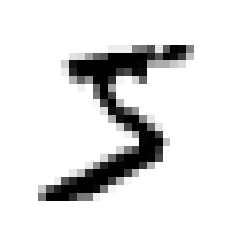

In [6]:
plt.imshow(X[0].reshape(28, 28), cmap=mpl.cm.binary)
plt.axis(False)
plt.show()

Так как **y** имеет строковый формат, преобразуем их в int.

In [7]:
y = y.astype(int)
y

array([5, 0, 4, ..., 4, 5, 6])

In [8]:
def draw_image(images, images_per_row=5):
    for index, image in enumerate(images):
        image = image.reshape(28, 28)
        n_rows = (len(images)-1) // images_per_row + 1
        plt.subplot(n_rows, images_per_row, index+1)
        plt.imshow(image, cmap=mpl.cm.binary)
        plt.axis(False)

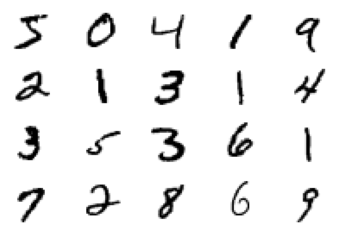

In [35]:
draw_image(X[:20])

In [10]:
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# Бинарный классификатор

Создадим бинарный классификатор, оценивающий является ли число цифрой `1` или нет. Это делается для того, чтобы потом посмотреть как оценивать производительность классификатора.

In [21]:
y_train_1 = (y_train == 1).astype(int)
y_test_1 = (y_test == 1).astype(int)

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [23]:
clf = SGDClassifier()
clf.fit(X_train, y_train_1)

SGDClassifier()

In [34]:
cross_val_score(clf, X_train, y_train_1, cv=5, scoring='accuracy')

array([0.99016667, 0.99025   , 0.98891667, 0.98225   , 0.99116667])

Как можно заметить, модель довольно точно классифицирует единицу.

In [41]:
clf.predict(X[:20])

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## Матрица ошибок

Создадим свой глупый классификатор, который будет говорить, что все классы не равны 1.

In [43]:
from sklearn.base import BaseEstimator

In [44]:
class Not1Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1))

In [49]:
not1_clf = Not1Classifier()
cross_val_score(not1_clf, X_train, y_train_1, cv=5, scoring='accuracy')

array([0.88741667, 0.88491667, 0.88491667, 0.88691667, 0.894     ])

Как можно заметить, точность почти 90%! Однако, такой классификатор не является точным абсолютно. Всё дело в том, что 9 из 10 цифр удовлетворяют условию "не единица" и именно поэтому точность такого классификатора почти 90%.

Поэтому очень часто для классификации применяют иные методы анализа. К примеру, матрицу неточностей.

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [51]:
pred = cross_val_predict(not1_clf, X_train, y_train_1, cv=5)

In [52]:
confusion_matrix(y_train_1, pred)

array([[53258,     0],
       [ 6742,     0]])

Как можно заметить, данный классификатор не определил ни один образец, как **положительный класс**.

Вспомним, что по горизонтали указаны **предсказанные классы**, а по вертикали - **фактические**. При этом, 1-й класс - **отрицательный**, 2-й - **положительный**.

In [54]:
pred = cross_val_predict(clf, X_train, y_train_1, cv=5)
confusion_matrix(y_train_1, pred)

array([[52790,   468],
       [  653,  6089]])

## Точность, полнота и F1

Выше продемонстрирован более справедливый классификатор, который определил положительный класс у 6 тысяч цифр, сделав ошибки 1-го и 2-го рода. Чтобы как-то оценить матрицу неточностей, существуют показатели **точности** и **полноты**, а также их среднее гармоническое - **f1** мера.

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [56]:
precision_score(y_train_1, pred)

0.9286258959890193

In [57]:
recall_score(y_train_1, pred)

0.9031444675170572

In [59]:
f1_score(y_train_1, pred)

0.9157079479660125

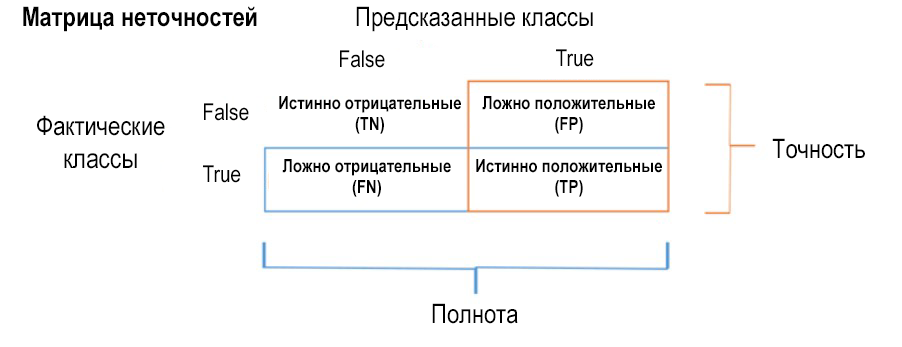

In [61]:
from IPython.display import Image
Image(data="./Confusion matrix.png")

Посмотрим теперь, как мы можем повлиять на границу принятия решения. Ниже представлено количество очков для цифры 1 и для цифры 9 соответственно. Выше показаны точность и полнота при стандартной границе.

In [83]:
clf.decision_function([X[3]]), clf.decision_function([X[4]])

(array([5062.80405088]), array([-38058.3478905]))

Попробуем изменить границу принятия решения и заметим, как изменятся показатели точности и полноты. Ровно так же для любой задачи можно изменить эти показатели в пользу б**о**льшей точности или полноты.

In [89]:
threshold = 4000
pred_new_threashold = (clf.decision_function(X_train) > threshold).astype(int)

In [91]:
precision_score(y_train_1, pred_new_threashold), recall_score(y_train_1, pred_new_threashold)

(0.9928033472803347, 0.8798576090180955)

Теперь нарисуем график точности-полноты с помощью **sklearn** и посмотрим как будут изменяться эти показатели при разных **границах** на графике.

In [92]:
from sklearn.metrics import precision_recall_curve

In [93]:
pred = cross_val_predict(clf, X_train, y_train_1, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, pred)

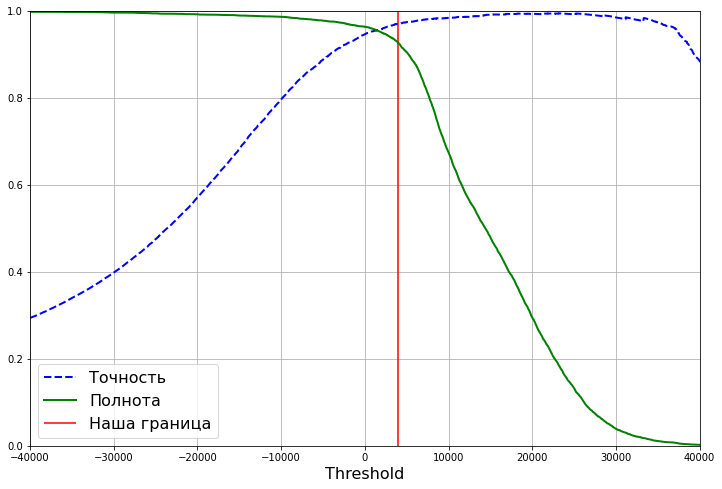

In [111]:
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Точность", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Полнота", linewidth=2)
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-40000, 40000, 0, 1])             
plt.vlines(threshold, 0, 1, color='red', label='Наша граница')
plt.legend(loc="lower left", fontsize=16)
plt.show()

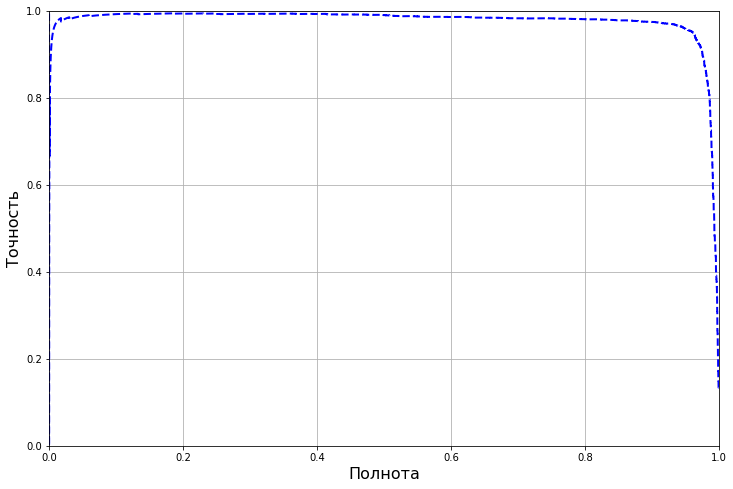

In [114]:
plt.figure(figsize=(12, 8))
plt.plot(recalls, precisions, "b--", linewidth=2)
plt.xlabel("Полнота", fontsize=16)   
plt.ylabel("Точность", fontsize=16)        
plt.grid(True)                              
plt.axis([0, 1, 0, 1])             
plt.show()

In [133]:
threshold = thresholds[np.argmax(precisions >= 0.99)]
threshold

14311.635663234698

In [135]:
y_train_pred_99 = (clf.decision_function(X_train) > threshold).astype(int)
precision_score(y_train_1, y_train_pred_99), recall_score(y_train_1, y_train_pred_99)

(0.9988776655443322, 0.1320083061406111)